# CosmoDC

### Goals
- How to interface QP and sacc
- How to create n(z) uncertainties from an ensemble of n(z)'s

### Requirements
- **A sacc file**: we will use the sacc file of Prat et al 2022 (2212.09345). This sacc file contains the summary statistics measured from the CosmoDC2 simulations using the DESC TXPipe pipeline. The summary statistics include the angular power spectra of the shear-shear, position-shear, and position-position correlations, as well as the cross-correlations between the different probes. The sacc file also contains the redshift distributions of the galaxies in the simulations. For more details see Prat et al 2022. The data can found in NERSC at '/global/cfs/cdirs/lsst/groups/WL/projects/star-challenge/gaussian/data_vectors'.

- **A series of QP ensenbles**: For this tutorials I have created a series of QP ensembles using the cosmoDC2_v1.1.4_image_with_photoz_v1 simulations. This catalog contains photometric redshifts that were computed with the `BPZ` template-based code (https://ui.adsabs.harvard.edu/abs/2000ApJ...536..571B/abstract) by Sam Schmidt. We use all the available pixels and impose a 24.1 magnitude cut in the i-band following Prat et al. The edges of the tomographic bins are also taken from Prat et al.

### Special Dependencies
- **sacc**: standard DESC library to load and save data.
- **rail.rail_prior**: this very own library, used to compute n(z) uncertainties from n(z) ensembles.
- **PACC** is a plotting library (https://github.com/JaimeRZP/pacc) for sacc files.

In [1]:
import numpy as np
from numpy.linalg import cholesky
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import scipy.stats as stats
import qp
import sacc
import yaml

import rail.rail_prior as rail_prior
import pacc

### Load Data

In [2]:
# Sacc file
s = sacc.Sacc.load_fits("/home/jaimerz/Documents/UCL/3x2_analytical/data/CosmoDC2/summary_statistics_fourier_tjpcov.sacc")
y = yaml.load(open("/home/jaimerz/Documents/UCL/3x2_analytical/data/CosmoDC2/gcgc_gcwl_wlwl.yml"), Loader=yaml.FullLoader)

# Ensembles
source_0 = np.load('/home/jaimerz/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs/shear_0.npz', allow_pickle=True)
source_1 = np.load('/home/jaimerz/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs/shear_1.npz', allow_pickle=True)
source_2 = np.load('/home/jaimerz/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs/shear_2.npz', allow_pickle=True)
source_3 = np.load('/home/jaimerz/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs/shear_3.npz', allow_pickle=True)
source_4 = np.load('/home/jaimerz/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs/shear_4.npz', allow_pickle=True)

lens_0 = np.load('/home/jaimerz/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs/lens_0.npz', allow_pickle=True)
lens_1 = np.load('/home/jaimerz/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs/lens_1.npz', allow_pickle=True)
lens_2 = np.load('/home/jaimerz/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs/lens_2.npz', allow_pickle=True)
lens_3 = np.load('/home/jaimerz/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs/lens_3.npz', allow_pickle=True)
lens_4 = np.load('/home/jaimerz/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs/lens_4.npz', allow_pickle=True)

tomos = {'source_0': source_0,
        'source_1': source_1,
        'source_2': source_2,
        'source_3': source_3,
        'source_4': source_4,
        'lens_0': lens_0,
        'lens_1': lens_1,
        'lens_2': lens_2,
        'lens_3': lens_3,
        'lens_4': lens_4}

In [3]:
#cle = pacc.ClsEnsemble(s, y, label="CosmoDC2")
#pacc.plot_cls([cle], cle.pairs)

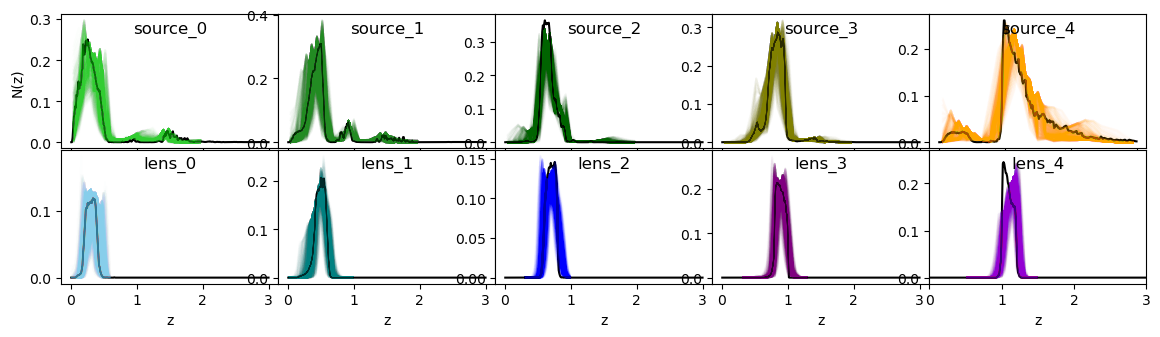

In [4]:
figure, axis = plt.subplots(2, 5, figsize=(14, 3.5))
figure.subplots_adjust(wspace=0, hspace=0.01)

colors = ['limegreen', 'forestgreen', 'darkgreen', 'olive', 'orange']
lens_keys = ['source_0', 'source_1', 'source_2', 'source_3', 'source_4']
for i, key in enumerate(lens_keys):
    tomo = tomos[key]
    spec = s.tracers[key]
    photo_dz = np.mean(np.diff(tomo['znodes']))
    spec_dz = np.mean(np.diff(spec.z))
    alpha = photo_dz/spec_dz
    norm = np.sum(np.mean(tomo['photo_hists'], axis=1))
    axis[0, i].plot(spec.z, alpha*spec.nz, 'k-')
    axis[0, i].plot(tomo['znodes'], tomo['photo_hists']/norm, '-', color=colors[i], alpha=0.01)
    #axis[0].plot(tomo['spec_zgrid'], alpha*tomo['photo_fid'], '-', color=colors[i], label=key)
    axis[0, i].set_title(key, y=0.8)
    axis[0, i].set_xlabel('z')
    if i == 0:
        axis[0, i].set_ylabel('N(z)')

colors = ['skyblue', 'teal', 'blue', 'purple', 'darkviolet']
lens_keys = ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4']
for i, key in enumerate(lens_keys):
    tomo = tomos[key]
    spec = s.tracers[key]
    photo_dz = np.mean(np.diff(tomo['znodes']))
    spec_dz = np.mean(np.diff(spec.z))
    alpha = photo_dz/spec_dz
    norm = np.sum(np.mean(tomo['photo_hists'], axis=1))
    axis[1, i].plot(spec.z, alpha*spec.nz, 'k-')
    axis[1, i].plot(tomo['znodes'], tomo['photo_hists']/norm, '-', color=colors[i], alpha=0.01)
    #axis[1].plot(tomo['spec_zgrid'], alpha*tomo['photo_fid'], '-', color=colors[i], label=key)
    axis[1, i].set_title(key, y=0.8)
    axis[1, i].set_xlabel('z')
    if i == 0:
        axis[0, i].set_ylabel('N(z)')

#nzsum = np.sum(fz_df['pdf'])
#plt.plot(zgrid,nzsum,c='b',label=f"i<{magcut} sum p(z)")

plt.xlim([0.0, 3.0])
plt.show()

In [5]:
def make_nzs_plots(tracers_dict, tracer_list):
    n_tracers = len(tracer_list)
    figure, axis = plt.subplots(2, n_tracers, figsize=(n_tracers*3.5,7))
    figure.subplots_adjust(wspace=0, hspace=0.01)
    for i, key in enumerate(tracer_list):
        tomo = tracers_dict[key]
        nzs = tomo['photo_hists']
        zs = tomo['znodes']
        axis[0,i].plot(zs, nzs, 'k-', alpha=0.01)
        cov = np.cov(nzs)
        nz_mean = np.mean(nzs, axis=1)
        axis[0,i].errorbar(zs, nz_mean, yerr=np.sqrt(np.diag(cov)), fmt='k-')
        axis[0,i].set_xlim([min(zs), max(zs)])
        axis[0,i].set_title(key)
        if i == 0:
            axis[0,i].set_ylabel(r'$p(z)$')
        else:
            axis[0,i].set_yticklabels([])
        im = axis[1,i].imshow(abs(cov), aspect='auto',
                            origin='lower', cmap='gray',
                            extent=[min(zs), max(zs), max(zs), min(zs)])
        axis[1,i].set_xlabel(r'$z$')

    cbar_ax = figure.add_axes([0.905, 0.11, 0.02, 0.38])
    figure.colorbar(im, cax=cbar_ax)
    plt.show()

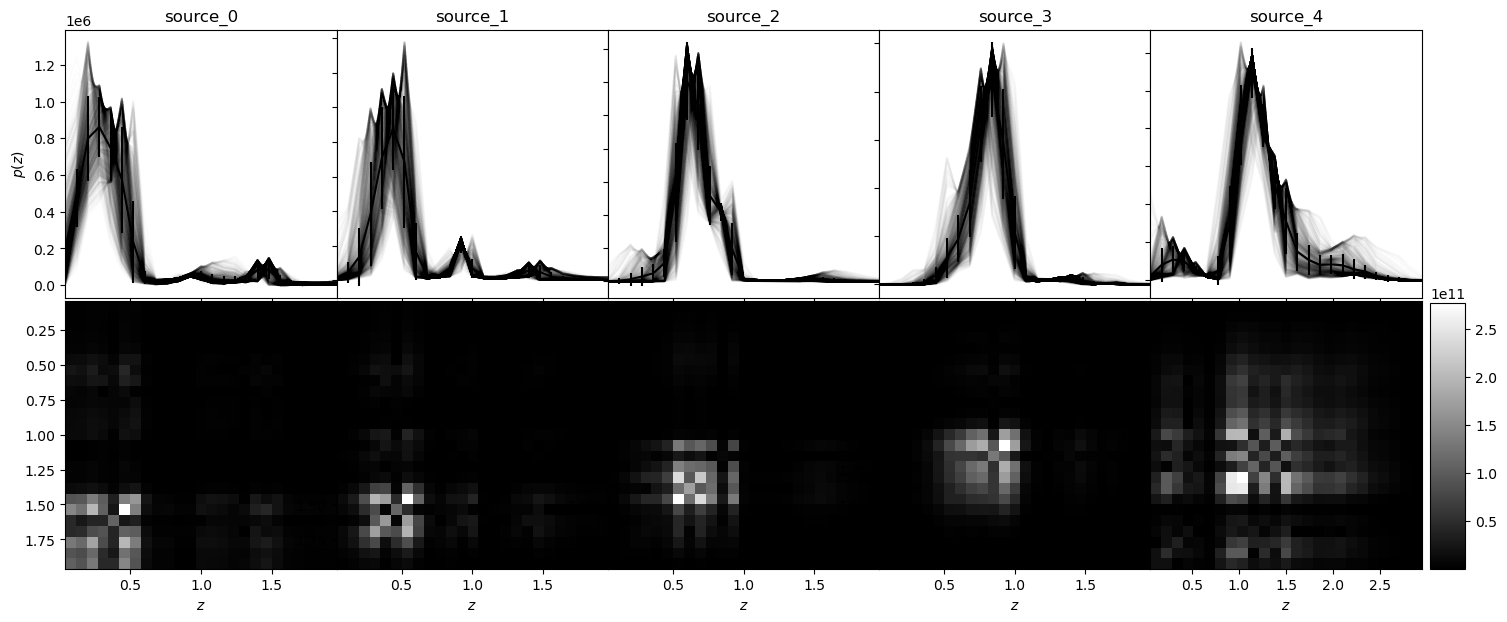

In [6]:
plot_tracers = ['source_0', 'source_1', 'source_2', 'source_3', 'source_4']
make_nzs_plots(tomos, plot_tracers)

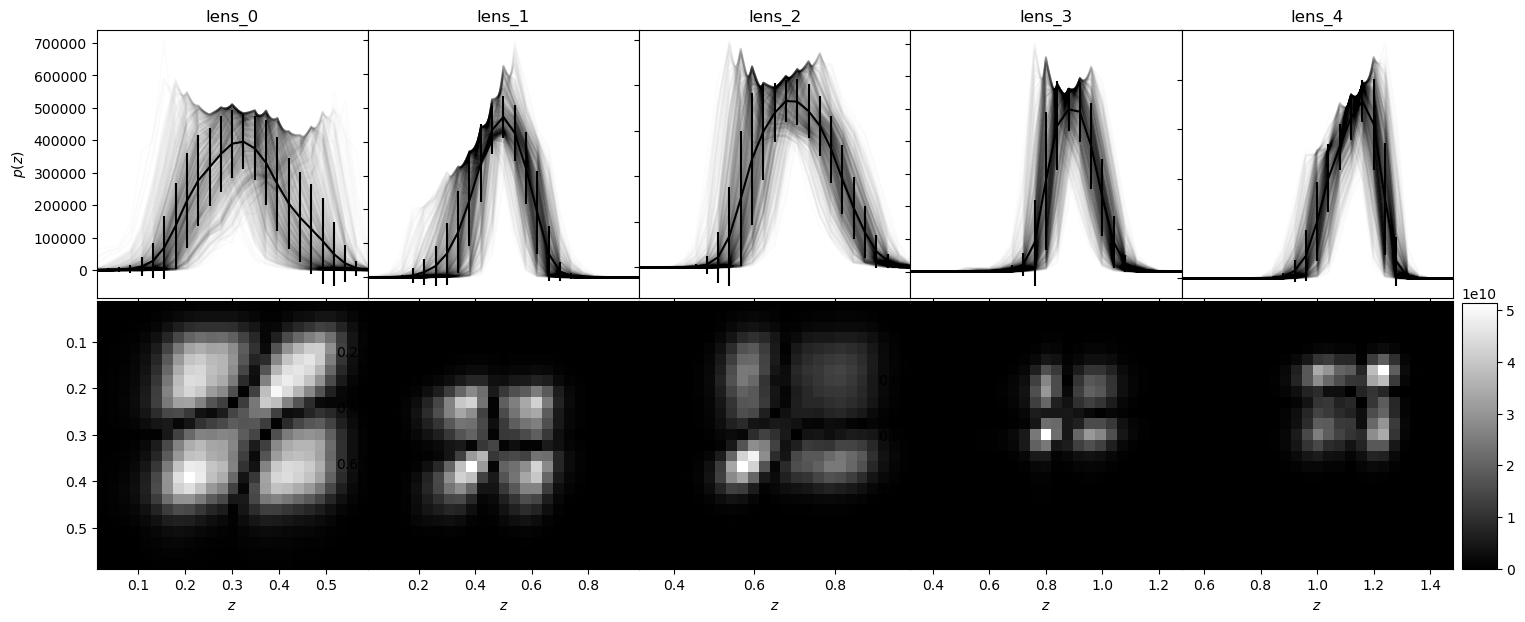

In [7]:
plot_tracers = ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4']
make_nzs_plots(tomos, plot_tracers)

# Interfacing SACC and QP

In [8]:
def make_qp(ens):
    pzs = ens['photo_hists'].T
    zs_edges = ens['zgrid']
    return qp.Ensemble(qp.hist, data={"bins":zs_edges, "pdfs":pzs})

def update_sacc_qp(s, enss):
    ss = s.copy()
    tracers = ss.tracers
    if tracers.keys() != enss.keys():
        raise ValueError("Tracers in sacc file and ensembles do not match")
    for key in tracers.keys():
        ens = enss[key]
        q = make_qp(ens)
        ss.add_tracer('Qpnz', key, q)
    return ss

ss_qp = update_sacc_qp(s, tomos)

# Computing Uncertainties

Now we are just going to apply the methods of rail_prior described in the basic tutorial for each of the tracers in the sacc file. For the sake of brevity we will only use the qp tracers but the same can be done for the NZTracers.

## Shifts

In [9]:
shifts_priors = rail_prior.PriorSacc(ss_qp, model="Shifts")

In [10]:
shifts_priors.sample_prior()

{'source_0__delta_z': -2.114936183354397e-16,
 'source_1__delta_z': 3.1600958075605086e-16,
 'source_2__delta_z': -4.944655235027629e-16,
 'source_3__delta_z': -1.198867036092579e-16,
 'source_4__delta_z': 2.6418569163253245e-16,
 'lens_0__delta_z': 3.9867474040634686e-17,
 'lens_1__delta_z': 2.744418296355171e-16,
 'lens_2__delta_z': 2.224918939058485e-16,
 'lens_3__delta_z': -1.227794126973118e-16,
 'lens_4__delta_z': -1.711248097850164e-16}

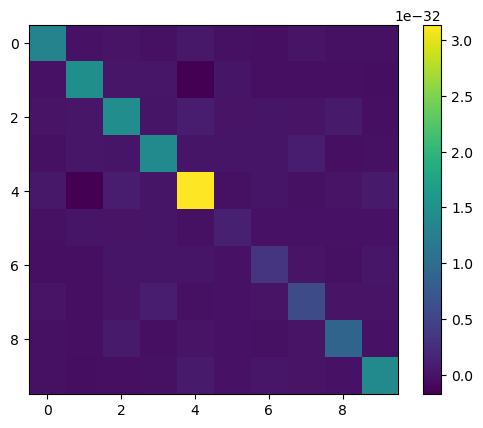

In [11]:
cov = np.cov(shifts_priors.params)
err = np.sqrt(np.diag(cov))
corr = cov/np.outer(err, err) 
plt.imshow(cov)
plt.colorbar()

In [12]:
shifted_nzs = {}
for i in range(1000):
    prior_sample = shifts_priors.sample_prior()
    for tracer_name in list(ss_qp.tracers.keys()):
        tracer = ss_qp.tracers[tracer_name]
        param_name = tracer_name + "__delta_z"
        shift = prior_sample[param_name]
        nz_fid = [tracer.z, tracer.nz]
        shifted_nz = rail_prior.shift_model(nz_fid, shift)[1]
        if i == 0:
            shifted_nzs[tracer_name] = [tracer.z, shifted_nz]
        else:

            shifted_nzs[tracer_name] = [tracer.z, np.vstack([shifted_nzs[tracer_name][1], shifted_nz])]
    

In [13]:
def make_nzs_plots(tracers_dict, tracer_list):
    n_tracers = len(tracer_list)
    figure, axis = plt.subplots(2, n_tracers, figsize=(n_tracers*3.5,7))
    figure.subplots_adjust(wspace=0, hspace=0.01)
    for i, key in enumerate(tracer_list):
        zs, nzs = tracers_dict[key]
        nzs = nzs.T
        axis[0,i].plot(zs, nzs, 'k-', alpha=0.01)
        cov = np.cov(nzs)
        nz_mean = np.mean(nzs, axis=1)
        #axis[0,i].errorbar(zs, nz_mean, yerr=np.sqrt(np.diag(cov)), fmt='k-')
        axis[0,i].set_xlim([min(zs), max(zs)])
        axis[0,i].set_title(key)
        axis[0,i].set_ylim([-0.01, 0.35])
        if i == 0:
            axis[0,i].set_ylabel(r'$p(z)$')
        else:
            axis[0,i].set_yticklabels([])
        im = axis[1,i].imshow(abs(cov), aspect='auto',
                            origin='lower', cmap='gray',
                            extent=[min(zs), max(zs), max(zs), min(zs)])
        axis[1,i].set_xlabel(r'$z$')

    cbar_ax = figure.add_axes([0.905, 0.11, 0.02, 0.38])
    figure.colorbar(im, cax=cbar_ax)
    plt.show()

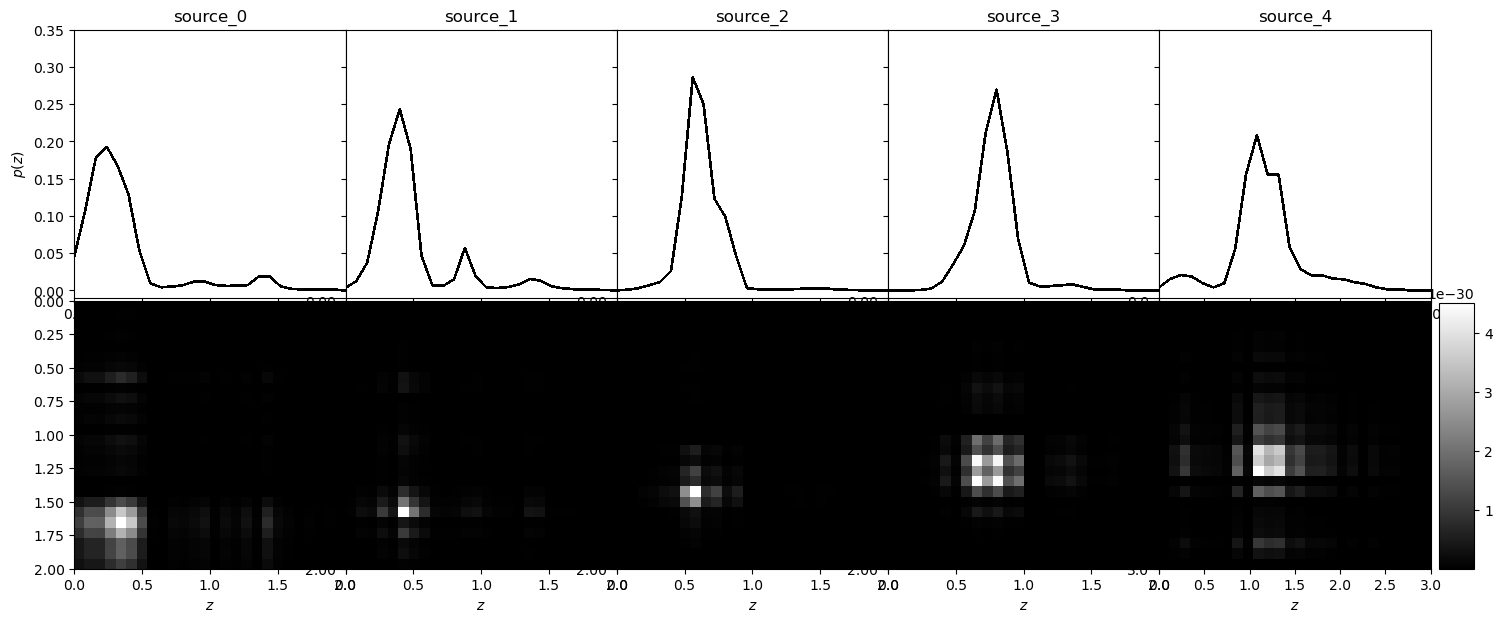

In [14]:
plot_tracers = ['source_0', 'source_1', 'source_2', 'source_3', 'source_4']
make_nzs_plots(shifted_nzs, plot_tracers)

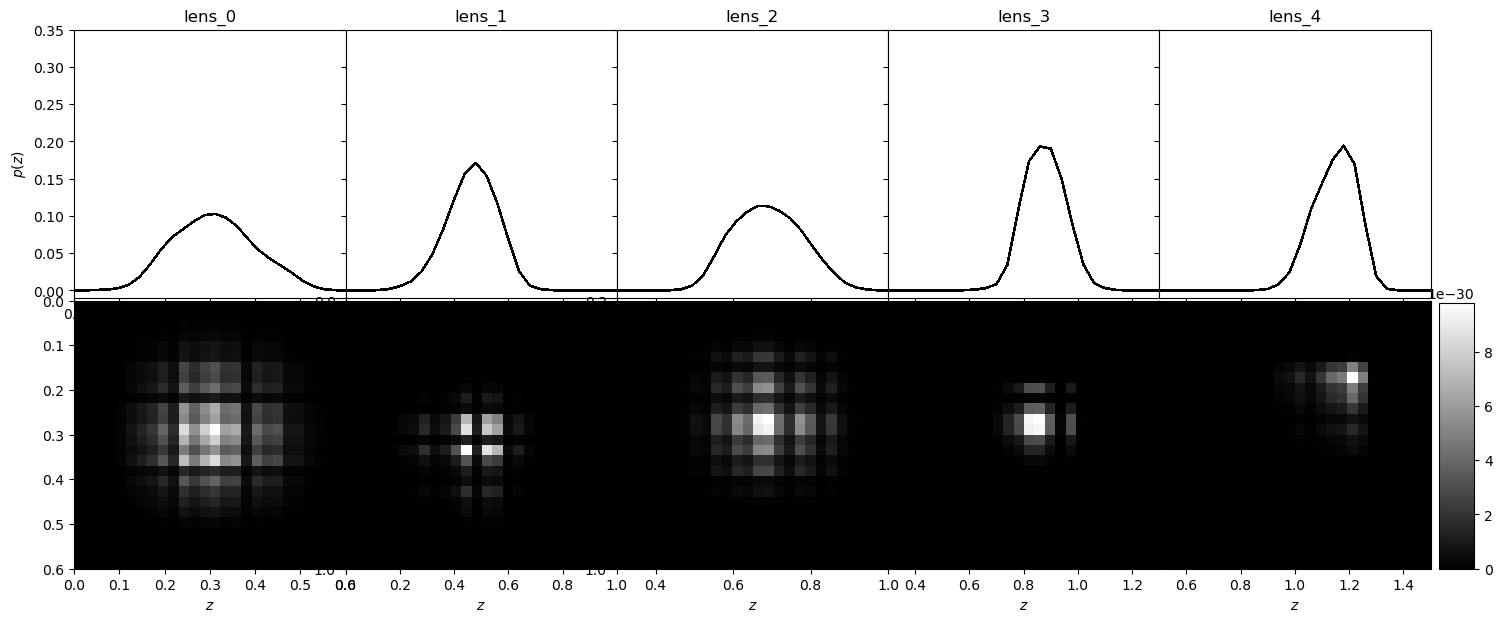

In [15]:
plot_tracers = ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4']
make_nzs_plots(shifted_nzs, plot_tracers)

## Shifts & widths

In [20]:
SnWs_priors = rail_prior.PriorSacc(ss_qp, model="ShiftsWidths")

In [21]:
SnWs_priors.sample_prior()

{'source_0__delta_z': -7.428749006154595e-17,
 'source_0__width_z': 0.9072943139025306,
 'source_1__delta_z': -1.0291448904635618e-09,
 'source_1__width_z': 0.9570003254207121,
 'source_2__delta_z': -4.1051215208566646e-10,
 'source_2__width_z': 0.9339218631302861,
 'source_3__delta_z': -5.670956048693312e-11,
 'source_3__width_z': 0.9859343538681669,
 'source_4__delta_z': -9.01576737473314e-12,
 'source_4__width_z': 0.8651967674281777,
 'lens_0__delta_z': 7.75798219213157e-17,
 'lens_0__width_z': 1.087462139020547,
 'lens_1__delta_z': 2.8351702609167405e-16,
 'lens_1__width_z': 1.0055208543755971,
 'lens_2__delta_z': 1.1817943279780994e-17,
 'lens_2__width_z': 1.0021812863071258,
 'lens_3__delta_z': -3.283696479343885e-16,
 'lens_3__width_z': 1.0065191368708353,
 'lens_4__delta_z': -5.716879489149654e-17,
 'lens_4__width_z': 1.0153097882260769}

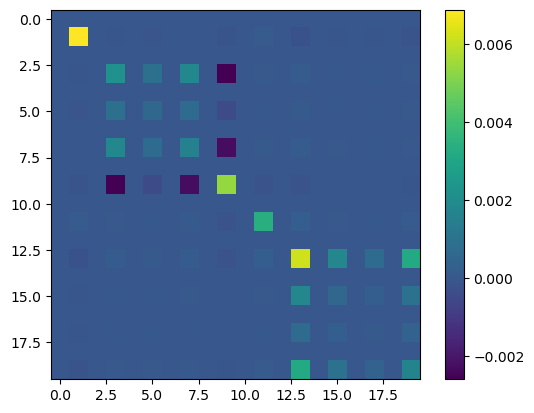

In [18]:
cov = np.cov(SnWs_priors.params)
err = np.sqrt(np.diag(cov))
corr = cov/np.outer(err, err) 
plt.imshow(cov)
plt.colorbar()

In [22]:
SnWs_nzs = {}
for i in range(1000):
    prior_sample = SnWs_priors.sample_prior()
    for tracer_name in list(ss_qp.tracers.keys()):
        tracer = ss_qp.tracers[tracer_name]
        shift = prior_sample[tracer_name + "__delta_z"]
        width = prior_sample[tracer_name + "__width_z"]
        nz_fid = [tracer.z, tracer.nz]
        shifted_nz = rail_prior.shift_and_width_model(nz_fid, shift, width)[1]
        if i == 0:
            SnWs_nzs[tracer_name] = [tracer.z, shifted_nz]
        else:

            SnWs_nzs[tracer_name] = [tracer.z, np.vstack([SnWs_nzs[tracer_name][1], shifted_nz])]

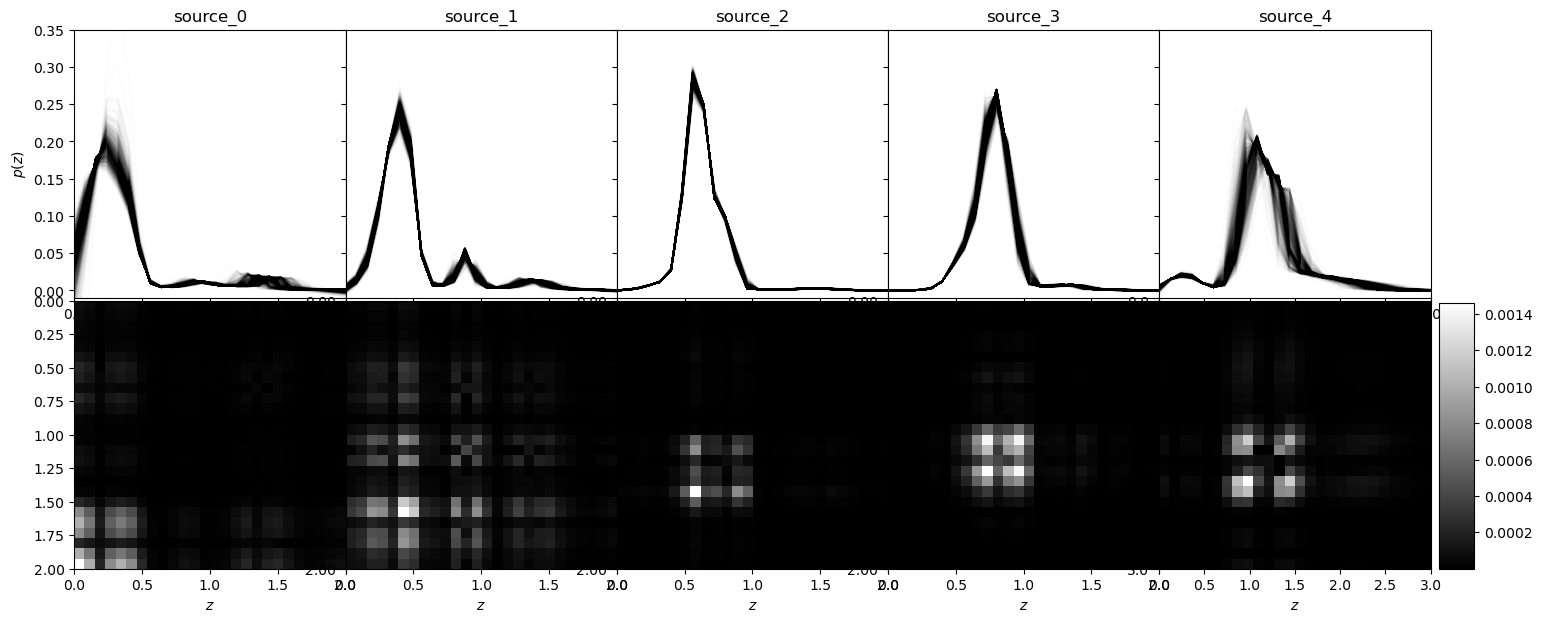

In [26]:
plot_tracers = ['source_0', 'source_1', 'source_2', 'source_3', 'source_4']
make_nzs_plots(SnWs_nzs, plot_tracers)

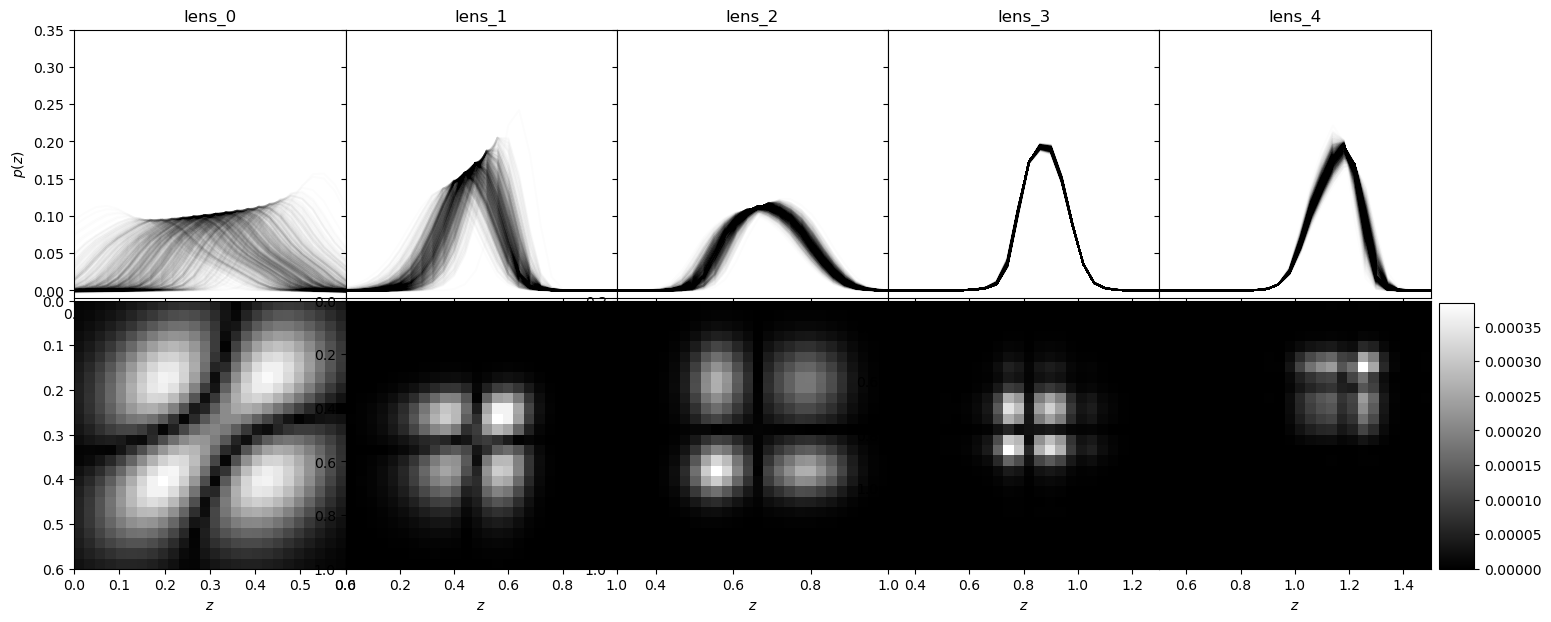

In [25]:
plot_tracers = ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4']
make_nzs_plots(SnWs_nzs, plot_tracers)

## Moments

In [ ]:
moments = {}
for tracer in ss_qp.tracers:
    print(tracer)
    ens = ss_qp.tracers[tracer].ensemble
    moment_obj = rail_prior.PriorMoments(ens)
    moments[tracer] = moment_obj

In [ ]:
moments_nzs = {}
for tracer in ss_qp.tracers:
    print(tracer)
    moments_obj = moments[tracer]
    pz_fid = [moments_obj.z, moments_obj.nz_mean]
    model = moments_obj.evaluate_model
    moments_nzs_tracer = np.array([model([pz_fid[0], moments_obj.sample_prior()])[1] for i in range(1000)])
    moments_nzs[tracer] = [moments_obj.z, moments_nzs_tracer.T]

In [ ]:
plot_tracers = ['source_0', 'source_1', 'source_2', 'source_3', 'source_4']
make_nzs_plots(moments_nzs, plot_tracers)

In [ ]:
plot_tracers = ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4']
make_nzs_plots(moments_nzs, plot_tracers)

In [ ]:
moments['source_0'].get_prior()